<center><h1>In your face:<br>Biased judgement of fear-anger expressions in violence offenders.</h1></center>

# 2. Analysis of Basic Emotion Recognition

This is an analysis of a basic emotion recognition paradigm, where 12 faces (6 female, 6 male) were shown to the participants, each displaying all basic expressions (happy, sad, angry, fearful, disgusted, suprised + neutral).  
Hence, there are 12 trials per expression and 12\*7=84 trials in total for each participant.

### importing modules

In [1]:
import numpy as np
import pandas as pd

import os
import fnmatch

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from myBasics import *

### get logfiles

In [2]:
def getLogfile(whichfolder, whichexperiment):

    loglist = []
    for fileName in os.listdir(whichfolder):
        if fnmatch.fnmatch(fileName, whichexperiment):
            loglist.append(whichfolder+fileName)
    return loglist

In [3]:
logList = getLogfile('../experiment/data/','*facesParametric*.csv')
logList.sort()

Example:

In [4]:
logList[:5]

['../experiment/data/A_10_facesParametric_2015_Sep_20_1307.csv',
 '../experiment/data/A_11_facesParametric_2015_Sep_25_1753.csv',
 '../experiment/data/A_12_facesParametric_2015_Oct_11_1221.csv',
 '../experiment/data/A_13_facesParametric_2015_Oct_11_1620.csv',
 '../experiment/data/A_14_facesParametric_2015_Nov_01_1250.csv']

### Extract Responses from logfile

In [5]:
def getBasicResps(fileName):
    df = pd.read_csv(fileName)

    ## merge scales into one column
    
    # convert None to NaN
    df = df.replace(r'None', np.nan, regex=True)
    df['basicRating1.response'] = df['basicRating1.response'].fillna(df['basicRating2.response']).fillna(df['basicRating3.response']).fillna(df['basicRating4.response'])
    df['basicRating1.rt'] = df['basicRating1.rt'].fillna(df['basicRating2.rt']).fillna(df['basicRating3.rt']).fillna(df['basicRating4.rt'])
   
    # boil down to just the essentials
    thisDf = pd.concat([df['img'],
                        df['basicRating1.response'],
                        df['basicRating1.rt']
                       ],axis=1)
    
    return thisDf[1:85]

Example: 

In [6]:
getBasicResps(logList[-1]).head()

,img,basicRating1.response,basicRating1.rt
1,./basicStim/21M_DI_O.jpg,HAP,18.338
2,./basicStim/28M_HA_O.jpg,HAP,6.682
3,./basicStim/23M_NE_C.jpg,ANG,3.406
4,./basicStim/07F_FE_O.jpg,DIS,2.154
5,./basicStim/07F_HA_O.jpg,HAP,1.73


## Get Conditions from Filenames

In [7]:
def getConds(df):
    
    df['conds'] = [entry[entry.find('_')+1:entry.rfind('_')] for entry in df['img'] ]
    df = df.sort_values(by='conds')
    df.index = [df['conds'],df.index]
    
    return df

Example:

In [8]:
getConds(getBasicResps(logList[-1])).head()

img basicRating1.response basicRating1.rt conds
conds                                                                         
AN    64  ./basicStim/24M_AN_O.jpg                   ANG           2.939    AN
      66  ./basicStim/07F_AN_O.jpg                   ANG           2.871    AN
      56  ./basicStim/34M_AN_O.jpg                   ANG           2.016    AN
      69  ./basicStim/36M_AN_O.jpg                   SUP           2.318    AN
      70  ./basicStim/21M_AN_O.jpg                   ANG           2.809    AN

### Evaluate whether response is correct or not (binary)

In [9]:
def addEval(df):
    
    resp = []
    for index,entry in enumerate( df['basicRating1.response'] ):
        # for each correct response, append a one
        if entry=='ANG' and df['conds'][index]=='AN':
            resp.append(1)
        elif entry=='DIS' and df['conds'][index]=='DI':
            resp.append(1)
        elif entry=='FEA' and df['conds'][index]=='FE':
            resp.append(1)
        elif entry=='HAP' and df['conds'][index]=='HA':
            resp.append(1)
        elif entry=='NTR' and df['conds'][index]=='NE':
            resp.append(1)
        elif entry=='SAD' and df['conds'][index]=='SA':
            resp.append(1)
        elif entry=='SUP' and df['conds'][index]=='SP':
            resp.append(1)   
        # all other responses must be incorrect; we append a zero
        else:
            resp.append(0)

    df['resp'] = resp
        
    return df

Example:

In [10]:
addEval(getConds(getBasicResps(logList[-1]))).head()

img basicRating1.response basicRating1.rt  \
conds                                                                      
AN    64  ./basicStim/24M_AN_O.jpg                   ANG           2.939   
      66  ./basicStim/07F_AN_O.jpg                   ANG           2.871   
      56  ./basicStim/34M_AN_O.jpg                   ANG           2.016   
      69  ./basicStim/36M_AN_O.jpg                   SUP           2.318   
      70  ./basicStim/21M_AN_O.jpg                   ANG           2.809   

         conds  resp  
conds                 
AN    64    AN     1  
      66    AN     1  
      56    AN     1  
      69    AN     0  
      70    AN     1

### Average over trials

Count and average the correct responses. Add a participant number to the index.

In [11]:
def getAvg(df,p):
    meanDf = pd.DataFrame([df.ix[cond]['resp'].mean()] for cond in df.index.levels[0])
    meanDf['cond'] = [cond for cond in df.index.levels[0]]
    meanDf.index = [[p]*len(meanDf.index), meanDf['cond'] ]
    meanDf.index.names = ['id','cond']
    
    return meanDf

Example:

In [12]:
getAvg(addEval(getConds(getBasicResps(logList[-1]))),'pXYZ').head()

0 cond
id   cond               
pXYZ AN    0.666667   AN
     DI    0.666667   DI
     FE    0.166667   FE
     HA    1.000000   HA
     NE    0.750000   NE

### Do all this for a participant

Takes all the functions from above and applies them directly to a logfile. Also gets the participant number form the logfile name.

In [13]:
def makeOne(fileName):
    df = getBasicResps(fileName)

    condDf = getConds(df)
    
    respDf = addEval(condDf)
    
    p = fileName[fileName.find('_')-1:fileName.find('faces')-1]
    avgDf = getAvg(respDf,p)
    return avgDf

Example:

In [14]:
makeOne(logList[-1])

0 cond
id  cond               
K_9 AN    0.666667   AN
    DI    0.666667   DI
    FE    0.166667   FE
    HA    1.000000   HA
    NE    0.750000   NE
    SA    0.083333   SA
    SP    0.833333   SP

## Do this for whole group

In [15]:
def makeBig(loglist):
    for logfile in loglist:
        thisDf = makeOne(logfile)
        withinDf = thisDf.drop('cond',1).unstack()
        
        try:
            bigDf = pd.concat([bigDf,withinDf])
        except:
            bigDf = withinDf
    
    groups = [a[0] for a in bigDf.index]
    
    bigDf.index = [groups, bigDf.index ]
    bigDf.index.names = ['group','id']
    bigDf.columns = bigDf.columns.droplevel()
    return bigDf

This is the main table for the analyses:

In [16]:
bigDf = makeBig(logList)

In [17]:
bigDf.head()

cond              AN        DI        FE        HA        NE        SA  \
group id                                                                 
A     A_10  1.000000  0.750000  0.416667  1.000000  0.916667  0.916667   
      A_11  0.916667  0.916667  0.833333  1.000000  0.666667  0.666667   
      A_12  0.666667  0.666667  0.083333  1.000000  0.916667  0.750000   
      A_13  0.833333  0.916667  0.416667  1.000000  0.916667  0.750000   
      A_14  1.000000  0.833333  0.250000  0.916667  1.000000  0.750000   

cond              SP  
group id              
A     A_10  0.500000  
      A_11  0.916667  
      A_12  0.833333  
      A_13  1.000000  
      A_14  0.916667

Save as csv for later re-use:

In [18]:
bigDf.to_csv('../outputs/basicExpressionsCorrect.csv')

## Basic Plotting

In [19]:
def makeBar(bigDf):
    fig = plt.figure(figsize=(12,8))
    add = 0
    for index,group in enumerate(bigDf.index.levels[0]):

        plt.bar(np.arange(0,14,2)+add,
                bigDf.ix[group].mean(),
                yerr=bigDf.ix[group].std()/np.sqrt(len(bigDf.ix[group]))*1.96,
                color=myPal[labelCoding[group]],
                ecolor='k',
                label=group)

        add+=0.5

    plt.legend(loc='lower right',bbox_to_anchor=(1.2,0.1))
    plt.xticks(np.arange(0,14,2)+1, bigDf.columns )
    sns.despine()
    plt.show()

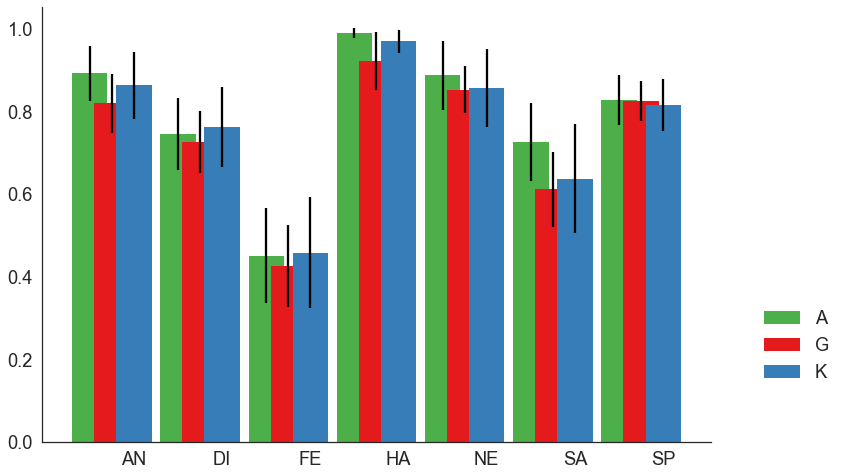

In [20]:
makeBar(bigDf)

## Responses with confusions

Extract information from dataFrame in a more systematic way:

In [21]:
def recodeResponses(df):
    g = []; e = []
    for i in df.index:
        thisImg = df.ix[i]['img']
        thisGender = thisImg[ thisImg.rfind('/')+3 ]
        thisEmo = thisImg[ thisImg.find('_')+1 : thisImg.find('_')+3 ]

        g.append(thisGender)
        e.append(thisEmo)
    
    df['fgender'] = g
    df['emo'] = e

    return df 

Example:

In [22]:
df = getBasicResps(logList[-1])

In [23]:
recodeResponses(df).head()

,img,basicRating1.response,basicRating1.rt,fgender,emo
1,./basicStim/21M_DI_O.jpg,HAP,18.338,M,DI
2,./basicStim/28M_HA_O.jpg,HAP,6.682,M,HA
3,./basicStim/23M_NE_C.jpg,ANG,3.406,M,NE
4,./basicStim/07F_FE_O.jpg,DIS,2.154,F,FE
5,./basicStim/07F_HA_O.jpg,HAP,1.73,F,HA


Get full range of responses to each expression:

In [24]:
def getAllResponses(df,p):
    
    d = {}

    # prepare dict
    for entry in df.index:
        d[df.ix[entry]['emo']] = { 'F':{'HAP':0,'SAD':0,'ANG':0,'FEA':0,'DIS':0,'SUP':0,'NTR':0},
                                   'M':{'HAP':0,'SAD':0,'ANG':0,'FEA':0,'DIS':0,'SUP':0,'NTR':0}
                                 }  
    # fill dict
    for entry in df.index:
        thisResp = df.ix[entry]['basicRating1.response']
        thisFace = df.ix[entry]['emo']
        thisFGender = df.ix[entry]['fgender']
        try:
            d[thisFace][thisFGender][thisResp] +=1
        except:
            pass


    bigDf = pd.DataFrame()
    for entry in d:
        thisDf = pd.DataFrame(d[entry])
        thisDf.index = [ [entry]*len(thisDf.index), thisDf.index ]
        bigDf = pd.concat([bigDf, thisDf])


    bigDf = bigDf.sort_index()
    bigDf = bigDf.T
    bigDf.index = [[p]*len(bigDf.index), bigDf.index]
    bigDf.index.names = ['pNum','fGender']

    return bigDf

Example:

In [25]:
getAllResponses(df,'pXXX')

AN                          DI         ...  SA          SP      \
             ANG DIS FEA HAP NTR SAD SUP ANG DIS FEA ... NTR SAD SUP ANG DIS   
pNum fGender                                         ...                       
pXXX F         4   1   0   0   0   0   1   1   5   0 ...   1   1   2   0   0   
     M         4   1   0   0   0   0   1   0   3   0 ...   0   0   2   0   0   

                                  
             FEA HAP NTR SAD SUP  
pNum fGender                      
pXXX F         0   1   0   0   5  
     M         0   1   0   0   5  

[2 rows x 49 columns]

In [26]:
pd.DataFrame( pd.DataFrame( getAllResponses(df,'pXXX').ix['pXXX'].ix['F'] ).unstack() )/6.*100

F                                                          \
          ANG        DIS        FEA         HAP        NTR        SAD   
AN  66.666667  16.666667   0.000000    0.000000   0.000000   0.000000   
DI  16.666667  83.333333   0.000000    0.000000   0.000000   0.000000   
FE   0.000000  33.333333   0.000000    0.000000   0.000000   0.000000   
HA   0.000000   0.000000   0.000000  100.000000   0.000000   0.000000   
NE   0.000000   0.000000  16.666667    0.000000  66.666667   0.000000   
SA   0.000000  33.333333   0.000000    0.000000  16.666667  16.666667   
SP   0.000000   0.000000   0.000000   16.666667   0.000000   0.000000   

               
          SUP  
AN  16.666667  
DI   0.000000  
FE  66.666667  
HA   0.000000  
NE  16.666667  
SA  33.333333  
SP  83.333333

### Showing full confusion matrix as heatmap

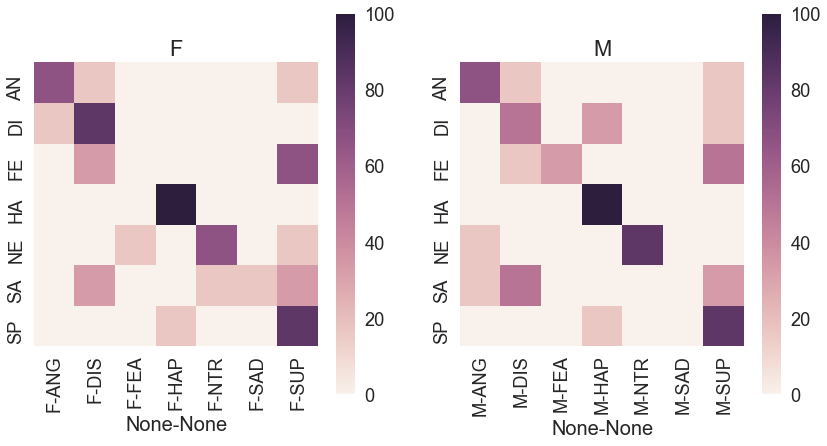

In [27]:
fig = plt.figure(figsize=(14,7))
for i,fGender in enumerate(['F','M']):
    confDf = pd.DataFrame( pd.DataFrame( getAllResponses(df,'pXXX').ix['pXXX'].ix[fGender] ).unstack() )/6.*100
    ax = plt.subplot('12'+str(i+1))
    sns.heatmap(confDf,square=True);
    ax.set_title(fGender)
plt.show()

### Do this for all participants

In [28]:
def confusionDf(loglist):
    allRespDf = pd.DataFrame()

    for logfile in loglist:
        
        rawDf = getBasicResps(logfile)
        pName = logfile[logfile.rfind('/')+1:logfile.find('_faces')]
        thisDf = getAllResponses( recodeResponses(rawDf),pName )

        allRespDf = pd.concat([allRespDf,thisDf])
    
    # some restructuring...
    allRespDf = allRespDf.unstack(1)
    groupIndex = [ x[0] for x in allRespDf.index ]
    allRespDf.index = [ groupIndex,allRespDf.index  ]
    allRespDf.columns = allRespDf.columns.swaplevel(0, 2)
    allRespDf.sortlevel(0, axis=1, inplace=True)
    allRespDf.columns = allRespDf.columns.swaplevel(1, 2)
    allRespDf.sortlevel(0, axis=1, inplace=True)
    return allRespDf/6. # divide by number of trials in each condition (12 faces)

In [29]:
confDf = confusionDf(logList)

Example:

In [30]:
confDf.head()

fGender         F                                                         \
               AN                                           DI             
              ANG  DIS       FEA  HAP  NTR  SAD  SUP       ANG       DIS   
  pNum                                                                     
A A_1    1.000000  0.0  0.000000  0.0  0.0  0.0  0.0  0.166667  0.833333   
  A_10   1.000000  0.0  0.000000  0.0  0.0  0.0  0.0  0.000000  0.833333   
  A_11   1.000000  0.0  0.000000  0.0  0.0  0.0  0.0  0.000000  1.000000   
  A_12   0.833333  0.0  0.166667  0.0  0.0  0.0  0.0  0.333333  0.666667   
  A_13   0.833333  0.0  0.166667  0.0  0.0  0.0  0.0  0.000000  1.000000   

fGender              ...            M                                     \
                     ...           SA                       SP             
              FEA    ...          NTR       SAD       SUP  ANG       DIS   
  pNum               ...                                                   
A A_1    0.000000    ...     0.000000  0.833333  0.000000  0.0  0.000000   
  A_10   0.166667    ...     0.000000  0.833333  0.000000  0.0  0.166667   
  A_11   0.000000    ...     0.000000  0.666667  0.000000  0.0  0.000000   
  A_12   0.000000    ...     0.000000  0.500000  0.333333  0.0  0.000000   
  A_13   0.000000    ...     0.166667  0.500000  0.000000  0.0  0.000000   

fGender                                          
                                                 
              FEA       HAP  NTR  SAD       SUP  
  pNum                                           
A A_1    0.166667  0.000000  0.0  0.0  0.833333  
  A_10   0.333333  0.000000  0.0  0.0  0.500000  
  A_11   0.000000  0.000000  0.0  0.0  1.000000  
  A_12   0.000000  0.166667  0.0  0.0  0.833333  
  A_13   0.000000  0.000000  0.0  0.0  1.000000  

[5 rows x 98 columns]

### Split the big plot into one for female, one for male faces

In [31]:
fConfDf = confDf['F']
mConfDf = confDf['M']

In [32]:
fConfDf.head()

AN                                           DI            \
             ANG  DIS       FEA  HAP  NTR  SAD  SUP       ANG       DIS   
  pNum                                                                    
A A_1   1.000000  0.0  0.000000  0.0  0.0  0.0  0.0  0.166667  0.833333   
  A_10  1.000000  0.0  0.000000  0.0  0.0  0.0  0.0  0.000000  0.833333   
  A_11  1.000000  0.0  0.000000  0.0  0.0  0.0  0.0  0.000000  1.000000   
  A_12  0.833333  0.0  0.166667  0.0  0.0  0.0  0.0  0.333333  0.666667   
  A_13  0.833333  0.0  0.166667  0.0  0.0  0.0  0.0  0.000000  1.000000   

                    ...      SA                       SP                 \
             FEA    ...     NTR       SAD       SUP  ANG  DIS       FEA   
  pNum              ...                                                   
A A_1   0.000000    ...     0.0  0.500000  0.166667  0.0  0.0  0.166667   
  A_10  0.166667    ...     0.0  1.000000  0.000000  0.0  0.0  0.333333   
  A_11  0.000000    ...     0.0  0.666667  0.000000  0.0  0.0  0.000000   
  A_12  0.000000    ...     0.0  1.000000  0.000000  0.0  0.0  0.000000   
  A_13  0.000000    ...     0.0  1.000000  0.000000  0.0  0.0  0.000000   

                                      
             HAP  NTR  SAD       SUP  
  pNum                                
A A_1   0.000000  0.0  0.0  0.833333  
  A_10  0.166667  0.0  0.0  0.500000  
  A_11  0.166667  0.0  0.0  0.833333  
  A_12  0.166667  0.0  0.0  0.833333  
  A_13  0.000000  0.0  0.0  1.000000  

[5 rows x 49 columns]

In [33]:
mConfDf.head()

AN                                           DI            \
             ANG       DIS  FEA  HAP  NTR  SAD  SUP       ANG       DIS   
  pNum                                                                    
A A_1   1.000000  0.000000  0.0  0.0  0.0  0.0  0.0  0.166667  0.833333   
  A_10  1.000000  0.000000  0.0  0.0  0.0  0.0  0.0  0.000000  0.666667   
  A_11  0.833333  0.166667  0.0  0.0  0.0  0.0  0.0  0.000000  0.833333   
  A_12  0.500000  0.500000  0.0  0.0  0.0  0.0  0.0  0.000000  0.666667   
  A_13  0.833333  0.166667  0.0  0.0  0.0  0.0  0.0  0.000000  0.833333   

                    ...           SA                       SP            \
             FEA    ...          NTR       SAD       SUP  ANG       DIS   
  pNum              ...                                                   
A A_1   0.000000    ...     0.000000  0.833333  0.000000  0.0  0.000000   
  A_10  0.166667    ...     0.000000  0.833333  0.000000  0.0  0.166667   
  A_11  0.000000    ...     0.000000  0.666667  0.000000  0.0  0.000000   
  A_12  0.000000    ...     0.000000  0.500000  0.333333  0.0  0.000000   
  A_13  0.000000    ...     0.166667  0.500000  0.000000  0.0  0.000000   

                                                
             FEA       HAP  NTR  SAD       SUP  
  pNum                                          
A A_1   0.166667  0.000000  0.0  0.0  0.833333  
  A_10  0.333333  0.000000  0.0  0.0  0.500000  
  A_11  0.000000  0.000000  0.0  0.0  1.000000  
  A_12  0.000000  0.166667  0.0  0.0  0.833333  
  A_13  0.000000  0.000000  0.0  0.0  1.000000  

[5 rows x 49 columns]

## Plotting of all responses (incl. confusions)

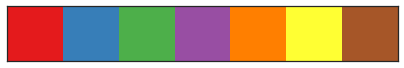

In [34]:
stackColors = sns.color_palette("Set1", 7)
sns.palplot(stackColors)

In [35]:
#http://stackoverflow.com/a/214657
def rgb2hex(rgb):
    return '#%02x%02x%02x' % rgb

In [36]:
def makeConfPlot(confDf,group,count):
    
    # we have 3 subplots here
    ax = plt.subplot(1,3,count)

    # order of face expressions is defined by hand here, instead of
    # using the columns, so the order is as we wish it to be
    faceExpressions = ['HA','NE','SP','AN','DI','SA','FE']
    faceAnswers = ['HAP','NTR','SUP','ANG','DIS','SAD','FEA']
    
    # we loop through all expressions
    for i,emo in enumerate( faceExpressions ):
        
        # since we build a stacked plot, we have to initialize a value that
        # tells us where to start. We start at the very bottom, hence 0
        sumSoFar = 0
        
        # we get the values of all conditions, and their names, as defined
        # in the index
        thisMean = confDf.ix[group][emo].mean()
        thisIndex = thisMean.index
        
        # firstly, we are interested in the correct response, which will be
        # always at the bottom of the stack plot and printed in a strong color
        
        # corrPos is the position of the current expression in the list of all expressions
        corrPos = faceExpressions.index(emo)
        # and we also get the name of the answer at this position (cave: the order of lists
        # must match!)
        corrEntry = faceAnswers[corrPos]

        # we get the positions of all the other answers
        incorrAnswers = faceAnswers[:corrPos]+faceAnswers[corrPos+1:]
        
        # we get the value of the correct answer
        entry = thisMean[corrEntry]
        # we get the name of the correct answer
        answer = faceAnswers[corrPos]
        
        # we take the color list and extract the color for the correct position
        thisColor = stackColors[corrPos]
        thisHex = rgb2hex( (thisColor[0]*255,thisColor[1]*255,thisColor[2]*255) )
        # the colors for the remaining 7-1 colors are stored here:
        incorrColors = stackColors[:corrPos]+stackColors[corrPos+1:]
        
            
        # this is the first bar we generate, it starts at the bottom (sumSoFar=0) and
        # has a strong color (alpha=1)
        ax.bar(i,
                entry,
                bottom=sumSoFar,
                color=thisHex,
                label=answer,
                alpha=1.)      
        
        # to stack the rest of the bars on top, we update the sum to be
        # the value (% correct) of the current condition
        sumSoFar = entry
        
        # we loop through the remaining (incorrect answers)
        for j,answer in enumerate(incorrAnswers):
            entry = thisMean[answer]

            thisColor = incorrColors[j]
            thisHex = rgb2hex( (thisColor[0]*255,thisColor[1]*255,thisColor[2]*255) )
            
            # same thing as above, but without the legend and with transparency
            ax.bar(i,
                    entry,
                    bottom=sumSoFar,
                    color=thisHex,
                    alpha=0.5
                        )           
            # for each run of the loop, we update the sumSoFar so we
            # always stack each expression at the top
            sumSoFar+=entry
    
    # get rid of figure box
    sns.despine()
    
    # x labels for each plot
    ax.set_xlabel('Basic Expression',fontsize=14)
    # y labels only for the first plot
    if i ==0:
        ax.set_ylabel('% of responses')
    else:
        ax.set_ylabel('')

    # axes annotation for all plots
    plt.xticks(np.arange(0,7.1,1)+0.4, faceExpressions,fontsize=12)
    plt.yticks(np.arange(0,1.01,0.1), [str(a)+'%' for a in  np.arange(0,101,10)],fontsize=14)

    ax.set_ylim(0,1)
    
    # getting the name of each subplot right
    groupNames = {'A':'General Population',
                  'G':'Violence Offenders',
                  'K':'Child Sex Offenders'
                 }
    ax.set_title(groupNames[group],position=(0.5,1.03) )
    
    # legend only at the very end (3rd plot)
    if count == 3:
        plt.legend(loc='best',bbox_to_anchor=[1,1])

In [37]:
def makeAllConfPlots(confDf):
    
    # loop through male and female faces
    for fGender in confDf.columns.levels[0][::-1]:
        
        plt.figure(figsize=(16,4))
        thisDf = confDf[fGender]
        
        # loop through participant groups
        for i,group in enumerate( ['G','K','A'] ):
            makeConfPlot(thisDf,group,i+1)

        # each plot gets a title...
        titleDict = {'M':'Male Faces','F':'Female Faces'}
        plt.suptitle(titleDict[fGender], position=(0.5, 1.1),fontsize=20)
        # ...and is saved seperately under a differnt name
        plt.savefig('../figures/basicEmoPlot_'+fGender+'.png',
                    dpi=300,
                    bbox_inches='tight')
        # show in notebook
        plt.show()    

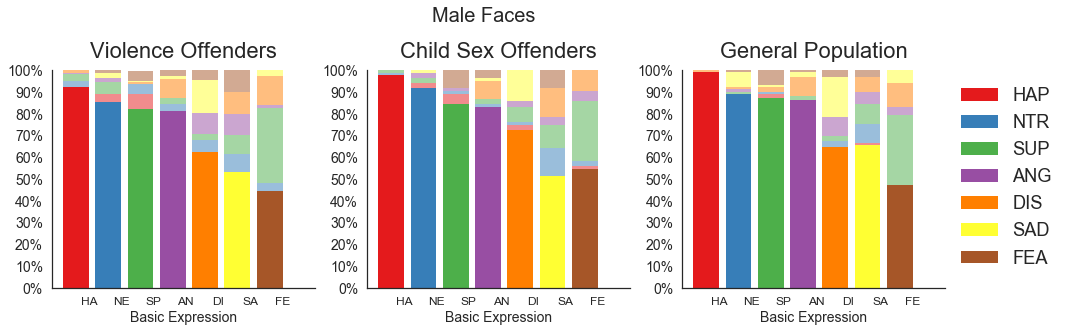

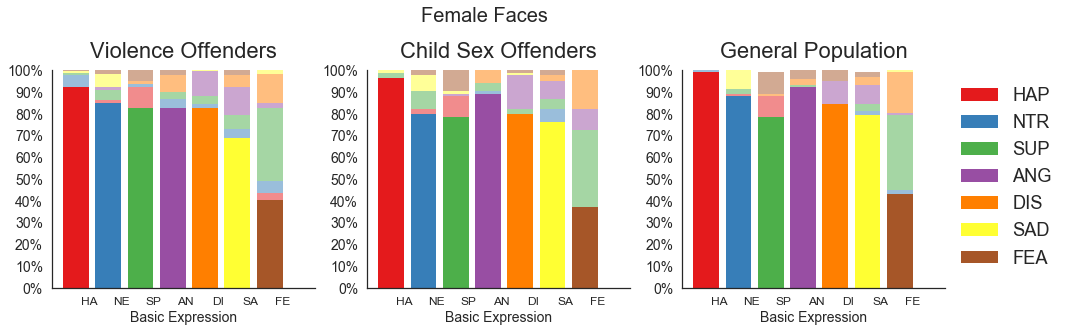

In [38]:
makeAllConfPlots(confDf)

## Getting a global emo score for each participant

This averages all correct responses, so we have one value per participant, which indicates percentage of correct responses overall.

In [39]:
bigDf.head()

cond              AN        DI        FE        HA        NE        SA  \
group id                                                                 
A     A_10  1.000000  0.750000  0.416667  1.000000  0.916667  0.916667   
      A_11  0.916667  0.916667  0.833333  1.000000  0.666667  0.666667   
      A_12  0.666667  0.666667  0.083333  1.000000  0.916667  0.750000   
      A_13  0.833333  0.916667  0.416667  1.000000  0.916667  0.750000   
      A_14  1.000000  0.833333  0.250000  0.916667  1.000000  0.750000   

cond              SP  
group id              
A     A_10  0.500000  
      A_11  0.916667  
      A_12  0.833333  
      A_13  1.000000  
      A_14  0.916667

In [40]:
globalCorrect = pd.DataFrame( bigDf.mean(axis=1) )
globalCorrect['group'] = [ labelCoding[x[0]] for x in globalCorrect.index.levels[1] ]
globalCorrect = globalCorrect.sort_values(by='group')

In [41]:
globalCorrect.head()

0  group
group id                   
G     G_22  0.654762      0
      G_16  0.607143      0
      G_17  0.761905      0
      G_18  0.738095      0
      G_19  0.821429      0

### Plot

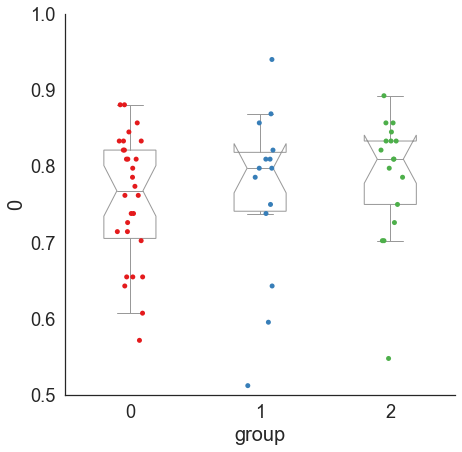

In [42]:
fig = plt.figure(figsize=(7,7))

sns.boxplot(x='group',y=0,data=globalCorrect,
            width=0.4,linewidth=1,color='white',whis=True,notch=True,fliersize=0)

sns.stripplot(x=globalCorrect['group'],y=globalCorrect[0],
              jitter=True,palette=stackColors)
sns.despine()
plt.ylim(0.5,1.);

### Make correct responses for male and female faces for 2x3x7 ANOVA in JASP

In [43]:
faceList = list(confDf.columns.levels[1])
respList = list(confDf.columns.levels[2])

jaspDf = pd.DataFrame()

for fGender in confDf.columns.levels[0]:

    for face in faceList:
        for resp in respList:
            if faceList.index(face) == respList.index(resp):
                thisDf =  confDf[fGender][face][resp] 
                thisDf.name = fGender+'_'+thisDf.name
                jaspDf = pd.concat([jaspDf,thisDf ],axis=1)
                
jaspDf['group'] = [ x[0] for x in jaspDf.index.levels[1]]

In [44]:
jaspDf.head()

F_ANG     F_DIS     F_FEA  F_HAP     F_NTR     F_SAD     F_SUP  \
  pNum                                                                      
A A_1   1.000000  0.833333  0.500000    1.0  0.166667  0.500000  0.833333   
  A_10  1.000000  0.833333  0.166667    1.0  1.000000  1.000000  0.500000   
  A_11  1.000000  1.000000  0.833333    1.0  0.833333  0.666667  0.833333   
  A_12  0.833333  0.666667  0.166667    1.0  1.000000  1.000000  0.833333   
  A_13  0.833333  1.000000  0.500000    1.0  0.833333  1.000000  1.000000   

           M_ANG     M_DIS     M_FEA  M_HAP     M_NTR     M_SAD     M_SUP  \
  pNum                                                                      
A A_1   1.000000  0.833333  0.333333    1.0  0.500000  0.833333  0.833333   
  A_10  1.000000  0.666667  0.666667    1.0  0.833333  0.833333  0.500000   
  A_11  0.833333  0.833333  0.833333    1.0  0.500000  0.666667  1.000000   
  A_12  0.500000  0.666667  0.000000    1.0  0.833333  0.500000  0.833333   
  A_13  0.833333  0.833333  0.333333    1.0  1.000000  0.500000  1.000000   

       group  
  pNum        
A A_1      A  
  A_10     A  
  A_11     A  
  A_12     A  
  A_13     A

In [45]:
jaspDf.to_csv('../outputs/basicExpressionsJASP.csv')